# Redo Marks fitness pred

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

In [92]:
import pandas as pd

train_date = pd.Timestamp("2020-07-01")  # or any date-like



em_path = "../params_by_period_0.03_m1_m8_m7/param_period_"+train_date.strftime("%Y-%m-%d")+".csv"
model=load_escape_map_from_csv(em_path)
seqs=Proteins_utils.load_FASTA('single_variants.fasta', drop_duplicates=False)
scores=-model(seqs)

scores.shape

(1401,)

Test set size = 1401


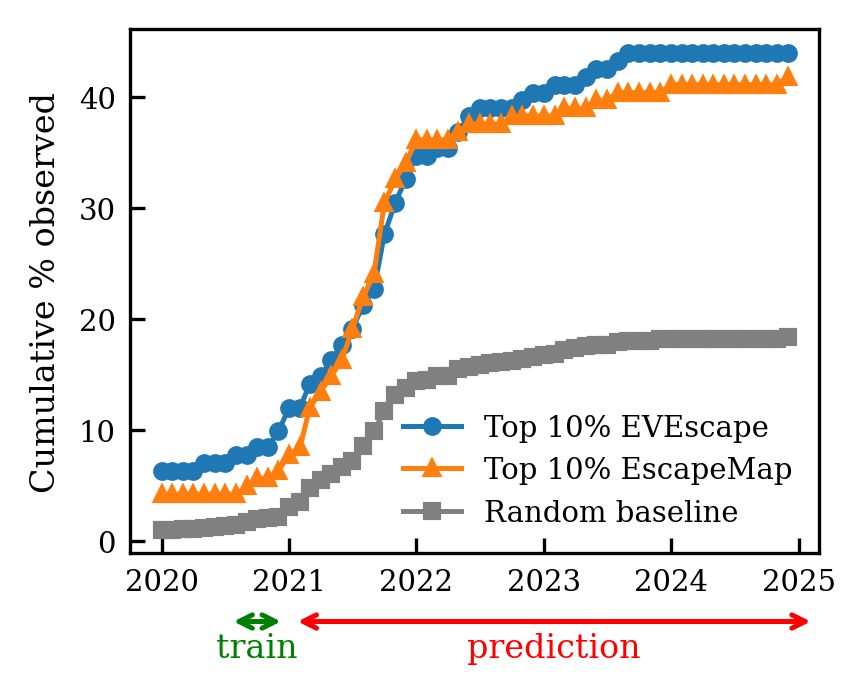

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# --- Load base ---
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['escapemap'] = scores

df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")
df_base.loc[df_base['count'] < 100, 'first_seen_100'] = pd.NaT  # mask low-count dates

th = 90  # percentile threshold

# ---------- Prepare frames (single pass, no seeds) ----------
df = df_base.copy()

# load EscapeMap scores
# col_em = "score" if "score" in df_em.columns else "scores"
df["escapemap"] = scores

print(f"Test set size = {len(df)}")

# thresholds
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)

# subsets (top 100-th % for each scoring scheme)
top_eve = df[df["evescape"]   >= thr_eve].copy()
top_em  = df[df["escapemap"]  >= thr_em].copy()

# drop NaT
with_seen_eve = top_eve.dropna(subset=["first_seen_100"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_eve, with_seen_em):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
tot_eve, tot_em = len(top_eve), len(top_em)
avg_eve = cum_frac(with_seen_eve, tot_eve, global_months)
avg_em  = cum_frac(with_seen_em,  tot_em,  global_months)

# random: percentage of total mutations that appeared in pandemic
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot (single curves, no seed averaging) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.0))

ax.plot(global_months, avg_eve, marker="o", label=f"Top {100-th}% EVEscape")
ax.plot(global_months, avg_em,  marker="^", label=f"Top {100-th}% EscapeMap")
ax.plot(global_months, avg_rnd, marker="s", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows placed lower ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = train_date+pd.DateOffset(months=6)  # extend train arrow 6 months right
x0 = train_date  # extend train arrow 6 months left

y = -0.13
xf = ax.get_xaxis_transform()  # data x, axes-fraction y

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)

plt.show()


## Effect of nucletoide substitutions

In [ ]:
# #open fasta file
# with open('../seq_data/wildtype_nucleotides.fasta') as f:
#     if f.readline().strip() != '>SARS-CoV-2':
#         print('Error: expected >SARS-CoV-2')
#     else:
#         wtnuc = f.readline().strip()

# print(wtnuc)
# #keep between BEGIN*3 and -END*3
# wtnuc=wtnuc[BEGIN*3:-END*3]
# #translate to aminoacids
# import Bio.Seq
# import Bio.SeqIO

# wtnucbio = Bio.Seq.Seq(wtnuc)
# wtnucbio = wtnucbio.translate()
# wtnucbio

AATATCACGAACCTTTGTCCTTTCGGTGAGGTCTTCAATGCTACTAGATTCGCATCCGTGTATGCATGGAATAGAAAGAGAATTAGTAATTGTGTAGCGGACTACTCTGTACTTTATAACTCCGCCTCCTTCTCCACATTCAAGTGTTACGGTGTATCTCCCACCAAGTTGAATGATCTATGCTTTACAAACGTTTACGCCGATAGTTTCGTAATTAGAGGCGATGAAGTGCGTCAGATCGCACCAGGCCAGACGGGCAAGATAGCAGACTATAATTATAAGCTGCCTGATGACTTCACCGGCTGTGTGATAGCTTGGAACTCAAATAATCTAGATTCCAAGGTGGGAGGCAATTACAATTATTTGTACCGTCTGTTCCGTAAAAGCAATTTGAAACCATTTGAAAGAGACATTAGCACTGAAATTTATCAAGCAGGGTCCACCCCGTGCAACGGCGTAGAAGGCTTTAACTGTTATTTCCCATTACAGTCTTATGGTTTCCAACCTACGAACGGAGTCGGGTATCAGCCGTACAGGGTTGTGGTTCTTTCATTTGAACTGCTGCACGCGCCCGCAACCGTATGCGGGCCGAAGAAATCAACG


Seq('SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVI...VCG')

In [ ]:
# codon_table = {
#     'A': ['GCT', 'GCC', 'GCA', 'GCG'],  # Alanine
#     'C': ['TGT', 'TGC'],  # Cysteine
#     'D': ['GAT', 'GAC'],  # Aspartic Acid
#     'E': ['GAA', 'GAG'],  # Glutamic Acid
#     'F': ['TTT', 'TTC'],  # Phenylalanine
#     'G': ['GGT', 'GGC', 'GGA', 'GGG'],  # Glycine
#     'H': ['CAT', 'CAC'],  # Histidine
#     'I': ['ATT', 'ATC', 'ATA'],  # Isoleucine
#     'K': ['AAA', 'AAG'],  # Lysine
#     'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],  # Leucine
#     'M': ['ATG'],  # Methionine (start codon)
#     'N': ['AAT', 'AAC'],  # Asparagine
#     'P': ['CCT', 'CCC', 'CCA', 'CCG'],  # Proline
#     'Q': ['CAA', 'CAG'],  # Glutamine
#     'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],  # Arginine
#     'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],  # Serine
#     'T': ['ACT', 'ACC', 'ACA', 'ACG'],  # Threonine
#     'V': ['GTT', 'GTC', 'GTA', 'GTG'],  # Valine
#     'W': ['TGG'],  # Tryptophan
#     'Y': ['TAT', 'TAC'],  # Tyrosine
#     'Z': ['TAA', 'TAG', 'TGA']  # Stop codons typically as 'Z' for demonstration, but usually don't correspond to any amino acid
# }

# STOP_KEYS = {"*", "STOP", "Z"}

# def one_nucleotide_away(site, wildtype_aa, mutant, wtnuc, codon_table):
#     site=site-349+1
#     # normalize
#     wt_aa = str(wildtype_aa).upper()
#     mut_aa = str(mutant).upper()
#     cds = str(wtnuc).upper().replace("U", "T")

#     # basic checks
#     if site < 1:
#         raise ValueError(f"site must be 1-based positive, got {site}")
#     start = (site - 1) * 3
#     if start + 3 > len(cds):
#         raise ValueError(f"site {site} out of range for CDS of length {len(cds)}")

#     wild_codon = cds[start:start+3]
#     # map mutant AA key for stops
#     if mut_aa in STOP_KEYS:
#         mut_aa = "Z"

#     # validate keys exist
#     if wt_aa not in codon_table:
#         raise KeyError(f"Unknown wildtype AA key '{wt_aa}' in codon_table")
#     if mut_aa not in codon_table:
#         # If you prefer: return False instead of raising
#         raise KeyError(f"Unknown mutant AA key '{mut_aa}' in codon_table")

#     # ensure wild codon is compatible with wildtype AA
#     if wild_codon not in codon_table[wt_aa]:
#         raise ValueError(
#             f"Wild codon {wild_codon} at site {site} does not encode '{wt_aa}' per codon table"
#         )

#     # Hamming distance == 1 to any mutant codon
#     for mc in codon_table[mut_aa]:
#         # skip identical codon: requires exactly one change
#         if sum(a != b for a, b in zip(wild_codon, mc)) == 1:
#             return True
#     return False


# # Apply the function to each row
# df_base['one_nucleotide_away'] = df_base.apply(lambda row: one_nucleotide_away(row['i'],row['wt'], row['mut'], wtnuc, codon_table), axis=1)
# df_base

,Unnamed: 0,i,wt,mut,bloom_ace2_binding,bloom_expression,chan_expression,chan_ace2_binding,fitness_eve,dissimilarity_charge_hydro,...,is_escape_experiment_all,mutation,count_marks,first_seen_marks,count_100,first_seen_100,count,first_seen,escapemap,one_nucleotide_away
135,135,349,S,A,-0.34,-1.13,-3.83,-2.68,-6.902246,-1.222299,...,False,S349A,53.0,NaN,30.0,NaT,30.0,2021-01,1473.891278,True
136,136,349,S,C,-0.12,-2.03,-1.77,-0.78,-7.368066,-1.609191,...,False,S349C,10.0,NaN,1.0,NaT,1.0,2022-05,1465.114789,True
137,137,349,S,F,-2.03,-2.50,-3.46,-2.75,-7.207227,-0.559057,...,False,S349F,16.0,NaN,11.0,NaT,11.0,2020-05,1465.114545,True
138,138,349,S,G,-0.59,-2.08,-1.04,-0.77,-6.908368,-1.388110,...,False,S349G,NaN,NaN,1.0,NaT,1.0,2022-04,1473.995770,False
139,139,349,S,I,-4.25,-2.69,-3.35,-1.95,-6.500989,-0.337976,...,False,S349I,NaN,NaN,NaN,NaT,NaN,NaN,1474.949607,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1531,526,G,E,-0.01,-0.13,NaN,NaN,-8.738202,1.067187,...,False,G526E,NaN,NaN,2.0,NaT,2.0,2020-10,1461.634315,True
1532,1532,526,G,R,-0.08,-0.30,NaN,NaN,-8.578857,3.241148,...,False,G526R,6.0,NaN,3.0,NaT,3.0,2021-10,1470.914498,True
1533,1533,526,G,S,-0.02,-0.14,NaN,NaN,-8.599188,-1.388110,...,False,G526S,NaN,NaN,NaN,NaT,NaN,NaN,1473.526973,False
1534,1534,526,G,V,-0.04,-0.12,NaN,NaN,-8.664563,-1.461803,...,False,G526V,5.0,NaN,1.0,NaT,1.0,2022-01,1471.828498,True


   index  one_nucleotide_away  n_non_nan
0      0                False   0.129683
1      1                 True   0.203036


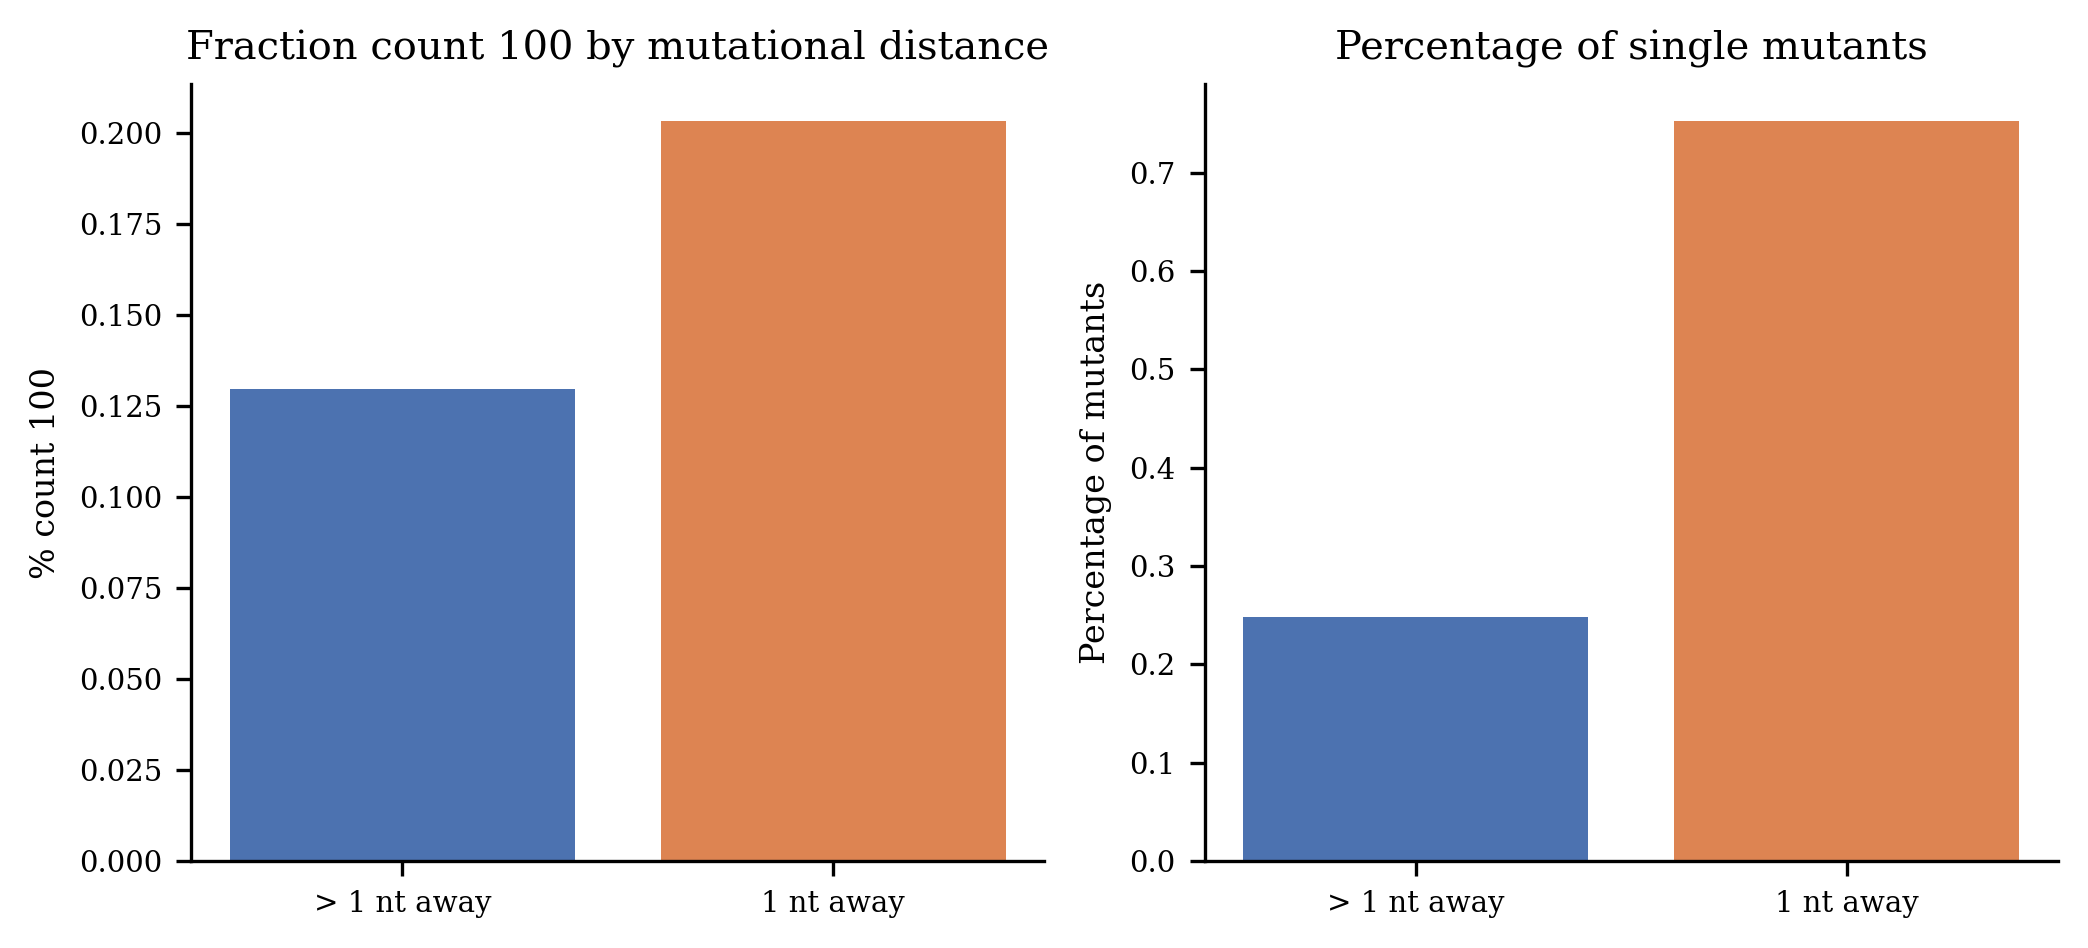

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Ensure boolean column 'one_nucleotide_away' exists
# # and that 'first_seen_100' and 'mut' are in df_base

# # --- 1. Compute percentage first_seen_100 != NAT ---
# grouped = (
#     df_base
#     .assign(valid_count100=lambda d: d['count']>100)
#     .groupby('one_nucleotide_away', as_index=False)
#     .agg(n_non_nan=('valid_count100', 'mean'))
#     .reset_index()
# )
# print(grouped)


# # --- 2. Count number of single mutants (1 row per mutant assumed) ---
# count_df = (
#     df_base
#     .groupby('one_nucleotide_away', as_index=False)
#     .size()
#     .rename(columns={'size': 'count'})
# )

# # --- Plot settings ---
# fig, axes = plt.subplots(1, 2, figsize=(7, 3.2))

# # First barplot: percentage non-NAT
# axes[0].bar(
#     grouped['one_nucleotide_away'].map({True: '1 nt away', False: '> 1 nt away'}),
#     grouped['n_non_nan'],#key error
#     color=['#4C72B0', '#DD8452']
# )
# axes[0].set_ylabel('% count 100')
# axes[0].set_title('Fraction count 100 by mutational distance')
# # axes[0].set_ylim(0, 100)

# # Second barplot: number of mutants
# axes[1].bar(
#     count_df['one_nucleotide_away'].map({True: '1 nt away', False: '> 1 nt away'}),
#     count_df['count']/len(df_base),
#     color=['#4C72B0', '#DD8452']
# )
# axes[1].set_ylabel('Percentage of mutants')
# axes[1].set_title('Percentage of single mutants')

# for ax in axes:
#     ax.spines[['top', 'right']].set_visible(False)
#     ax.set_xlabel('')

# plt.tight_layout()
# plt.show()


## Scoring of existing mutations

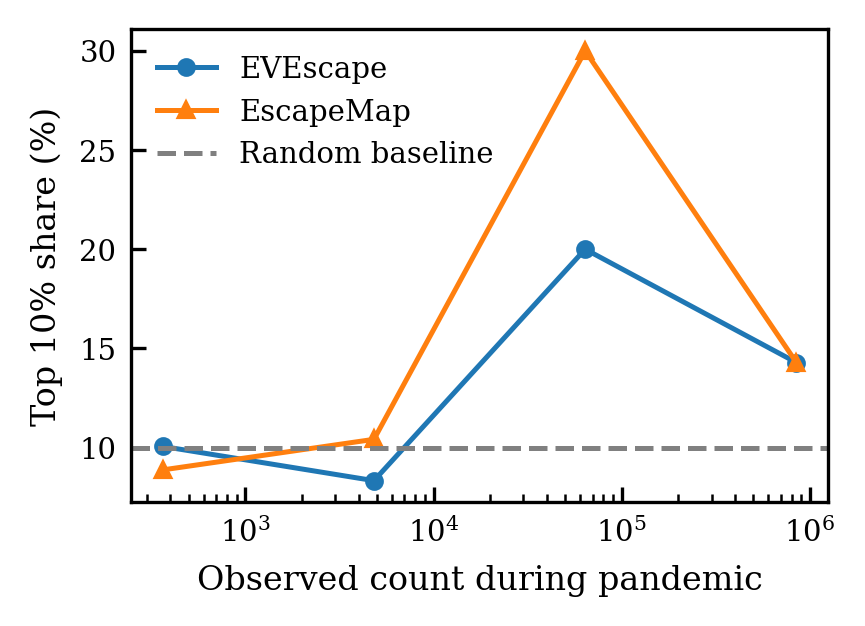

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ----------------- Params -----------------
NB_EDGES = 5           # number of log-space edges => NB_EDGES-1 bins
th = 90                # percentile threshold (top 5%)

# ----------------- Load & restrict to RBD -----------------
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")

# Use same EscapeMap data as previous plot
# df_base["escapemap"] = df_em[col_em].values
df_base["escapemap"] = scores
df_base['test'] = np.where(df_base['first_seen_100'] > train_date, 1, 0)

df_base=df_base[df_base['test']==1]
# Parse first_seen and pandemic window
df_base["first_seen_dt"] = pd.to_datetime(df_base["first_seen_100"], format="%Y-%m", errors="coerce")

pandemic_start = pd.Timestamp("2020-01-01")
pandemic_end   = pd.Timestamp("2026-01-01")  # exclusive
obs = df_base[(df_base["first_seen_dt"] >= pandemic_start) & (df_base["first_seen_dt"] < pandemic_end)].copy()

# ----------------- Build log-spaced frequency bins -----------------
freq = pd.to_numeric(obs["count"], errors="coerce").fillna(0).astype(float)
freq_clip = np.clip(freq.values, 1.0, None)   # clip zeros to 1 for binning

lo, hi = float(freq_clip.min()), float(freq_clip.max())
if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
    raise ValueError("Frequency range invalid; cannot create log bins.")

edges_log = np.linspace(np.log10(lo), np.log10(hi), NB_EDGES)
edges = 10.0 ** edges_log
midpoints = np.sqrt(edges[:-1] * edges[1:])  # geometric mean per bin

# Precompute bin masks for obs
bin_masks = []
for i in range(NB_EDGES - 1):
    left, right = edges[i], edges[i+1]
    if i < NB_EDGES - 2:
        bin_mask = (freq_clip >= left) & (freq_clip < right)
    else:
        bin_mask = (freq_clip >= left) & (freq_clip <= right)
    bin_masks.append(bin_mask)

# ----------------- Helper -----------------
def share_top_decile(values, threshold, base_mask):
    n = int(base_mask.sum())
    if n == 0:
        return np.nan
    return 100.0 * np.sum(values[base_mask] >= threshold) / n

# ----------------- Thresholds on FULL RBD set (seedless) -----------------
thr_eve_global = np.nanpercentile(df_base["evescape"], th)
thr_em_global  = np.nanpercentile(df_base["escapemap"], th)

# Values aligned to obs
eve_vals_obs = df_base.loc[obs.index, "evescape"].values
em_vals_obs  = df_base.loc[obs.index, "escapemap"].values

# ----------------- Per-bin shares (no test mask, no seeds) -----------------
eve_curve = []
em_curve  = []
for bin_mask in bin_masks:
    eve_curve.append(share_top_decile(eve_vals_obs, thr_eve_global, bin_mask))
    em_curve.append( share_top_decile(em_vals_obs,  thr_em_global,  bin_mask))

eve_curve = np.array(eve_curve, dtype=float)
em_curve  = np.array(em_curve,  dtype=float)

# ----------------- Random baseline -----------------
random_baseline = 100 - th  # e.g., 5 for top-5%

# ----------------- Plot -----------------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.0))
x = midpoints

line_eve, = ax.plot(x, eve_curve, marker="o", label="EVEscape")
line_em,  = ax.plot(x, em_curve,  marker="^", label="EscapeMap")

ax.axhline(random_baseline, linestyle="--", label="Random baseline", color="grey")

ax.set_xscale("log")
ax.set_xlabel("Observed count during pandemic")
ax.set_ylabel("Top "+str(100-th)+"% share (%)")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()


In [ ]:
df

,Unnamed: 0,i,wt,mut,bloom_ace2_binding,bloom_expression,chan_expression,chan_ace2_binding,fitness_eve,dissimilarity_charge_hydro,...,is_escape_experiment_all,mutation,count_marks,first_seen_marks,count_100,first_seen_100,count,first_seen,escapemap,one_nucleotide_away
135,135,349,S,A,-0.34,-1.13,-3.83,-2.68,-6.902246,-1.222299,...,False,S349A,53.0,NaN,30.0,NaT,30.0,2021-01,1473.891278,True
136,136,349,S,C,-0.12,-2.03,-1.77,-0.78,-7.368066,-1.609191,...,False,S349C,10.0,NaN,1.0,NaT,1.0,2022-05,1465.114789,True
137,137,349,S,F,-2.03,-2.50,-3.46,-2.75,-7.207227,-0.559057,...,False,S349F,16.0,NaN,11.0,NaT,11.0,2020-05,1465.114545,True
142,142,349,S,P,-0.11,-0.38,0.57,0.51,-6.455566,-1.811848,...,True,S349P,545.0,2021-09,383.0,2021-09-01,383.0,2020-05,1477.314598,True
144,144,349,S,T,-0.76,-1.93,-4.78,-3.00,-6.717688,-2.014505,...,False,S349T,6.0,NaN,10.0,NaT,10.0,2022-01,1475.078168,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,1528,526,G,A,-0.06,-0.26,NaN,NaN,-8.431933,-1.996082,...,False,G526A,5.0,NaN,NaN,NaT,NaN,NaN,1461.782460,True
1531,1531,526,G,E,-0.01,-0.13,NaN,NaN,-8.738202,1.067187,...,False,G526E,NaN,NaN,2.0,NaT,2.0,2020-10,1461.634315,True
1532,1532,526,G,R,-0.08,-0.30,NaN,NaN,-8.578857,3.241148,...,False,G526R,6.0,NaN,3.0,NaT,3.0,2021-10,1470.914498,True
1534,1534,526,G,V,-0.04,-0.12,NaN,NaN,-8.664563,-1.461803,...,False,G526V,5.0,NaN,1.0,NaT,1.0,2022-01,1471.828498,True


In [ ]:
import re, glob
import numpy as np
import pandas as pd

# ------------------ config & helpers ------------------
EM_DIR = "../params_by_period_0.03_m1_m8_m7"
first_period = pd.Timestamp("2020-01-01")  # anchor; we’ll filter >= this if useful

def parse_period_from_name(p):
    m = re.search(r"param_period_([0-9]{4}-[0-9]{2}-[0-9]{2})\.csv$", p)
    if not m:
        return None
    return pd.to_datetime(m.group(1), format="%Y-%m-%d", errors="coerce")

def list_available_periods(em_dir=EM_DIR, min_date=None):
    files = glob.glob(f"{em_dir}/param_period_*.csv")
    periods = sorted([parse_period_from_name(f) for f in files if parse_period_from_name(f) is not None])
    if min_date is not None:
        periods = [p for p in periods if p >= min_date]
    return periods

def roc_from_scores(y_true_bool: np.ndarray, s: np.ndarray):
    m = np.isfinite(s)
    y = y_true_bool[m].astype(int)
    s = s[m].astype(float)
    P = int(y.sum())
    N = int(len(y) - P)
    if P == 0 or N == 0 or len(y) == 0:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0]), np.nan
    order = np.argsort(s)[::-1]
    y_sorted = y[order]
    tp = np.cumsum(y_sorted)
    fp = np.cumsum(1 - y_sorted)
    tpr = np.r_[0.0, tp / P]
    fpr = np.r_[0.0, fp / N]
    auc = float(np.trapz(tpr, fpr))
    return fpr, tpr, auc

# Ensure seqs exist (your code already has this above; kept for robustness)
try:
    seqs
except NameError:
    seqs = Proteins_utils.load_FASTA("single_variants.fasta", drop_duplicates=False)

# ------------------ build period list (every 3 months from available files) ------------------
time_periods = list_available_periods(EM_DIR, min_date=first_period)
if len(time_periods) < 2:
    raise RuntimeError("Need at least two periods (train + next test period) in EM_DIR.")

# ------------------ storage for curves & AUCs ------------------
fpr_full_mut, tpr_full_mut, auc_full_mut = [], [], []
fpr_norbm_mut, tpr_norbm_mut, auc_norbm_mut = [], [], []

fpr_full_site, tpr_full_site, auc_full_site = [], [], []
fpr_norbm_site, tpr_norbm_site, auc_norbm_site = [], [], []

# ------------------ per-period evaluation ------------------
for train_date in time_periods[:-1]:
    em_path = f"{EM_DIR}/param_period_{train_date.strftime('%Y-%m-%d')}.csv"
    test_date = train_date + pd.DateOffset(months=3)  # next period window start
    test_end  = test_date + pd.DateOffset(months=3)   # next period window end

    # load models for this period
    model_full   = load_escape_map_from_csv(em_path)
    model_norbm  = load_escape_map_from_csv(em_path)
    model_norbm.raw_beta = -10.0  # suppress RBM viability penalty

    # scores for the same seq set
    scores_full  = -model_full(seqs)
    scores_norbm = -model_norbm(seqs)

    # base mutations table
    df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
    df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()

    # ensure date and optional count mask (keep consistent with your earlier code)
    df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")
    if "count" in df_base.columns:
        df_base.loc[df_base['count'] < 100, 'first_seen_100'] = pd.NaT

    # attach scores
    df_base["escapemap_full"]  = np.asarray(scores_full).ravel()
    df_base["escapemap_norbm"] = np.asarray(scores_norbm).ravel()

    # ---------------- candidate & label for "appears in next period" ----------------
    # Candidates: not seen before test_date (i.e., first_seen_100 is NaT or >= test_date)
    cand_mask = df_base['first_seen_100'].isna() | (df_base['first_seen_100'] >= test_date)
    # Positives: first seen within [test_date, test_end)
    label_mask = df_base['first_seen_100'].ge(test_date) & df_base['first_seen_100'].lt(test_end)
    y_true = label_mask[cand_mask].to_numpy()

    # Mutation-level ROC
    s_full  = df_base.loc[cand_mask, "escapemap_full"].to_numpy()
    s_norbm = df_base.loc[cand_mask, "escapemap_norbm"].to_numpy()

    fpr, tpr, auc = roc_from_scores(y_true, s_full)
    fpr_full_mut.append(fpr); tpr_full_mut.append(tpr); auc_full_mut.append(auc)

    fpr, tpr, auc = roc_from_scores(y_true, s_norbm)
    fpr_norbm_mut.append(fpr); tpr_norbm_mut.append(tpr); auc_norbm_mut.append(auc)

   

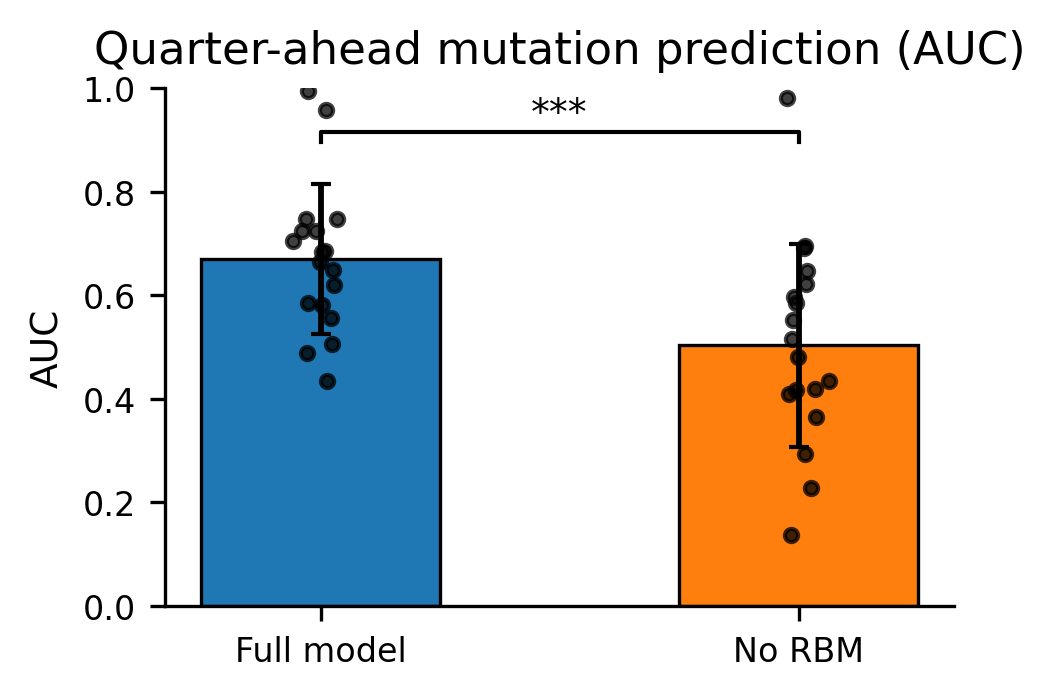

Paired t-test: p = 0.000247 (n = 18 periods)
Full:   mean±SD = 0.670 ± 0.144
NoRBM:  mean±SD = 0.504 ± 0.196


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# --- pull arrays (mutation-level only) ---
a_full  = np.asarray(auc_full_mut,  dtype=float)
a_norbm = np.asarray(auc_norbm_mut, dtype=float)

# paired finite mask
m = np.isfinite(a_full) & np.isfinite(a_norbm)
a_full_p, a_norbm_p = a_full[m], a_norbm[m]

# summary stats
mu_full  = float(np.nanmean(a_full_p))  if a_full_p.size  else np.nan
mu_nrbm  = float(np.nanmean(a_norbm_p)) if a_norbm_p.size else np.nan
sd_full  = float(np.nanstd(a_full_p,  ddof=1)) if a_full_p.size  > 1 else 0.0
sd_nrbm  = float(np.nanstd(a_norbm_p, ddof=1)) if a_norbm_p.size > 1 else 0.0

# paired t-test
p = ttest_rel(a_full_p, a_norbm_p).pvalue if (a_full_p.size and a_norbm_p.size) else np.nan

# optional Nature rc
try:
    nature_rc()
except Exception:
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 600,
        "axes.linewidth": 0.8, "lines.linewidth": 1.4,
        "font.size": 9, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 8,
        "legend.fontsize": 8, "font.family": "sans-serif",
    })

def star_for_p(pv: float) -> str:
    if not np.isfinite(pv): return "n.s."
    if pv < 1e-3: return "***"
    if pv < 1e-2: return "**"
    if pv < 5e-2: return "*"
    return "n.s."

def annotate_sig(ax, x1, x2, y, pval, h=0.02):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, color="black")
    ax.text((x1+x2)/2, y+h, star_for_p(pval), ha="center", va="bottom")

# --- plot ---
fig, ax = plt.subplots(figsize=(3.35, 2.4))  # Nature one-column friendly
x = np.array([0, 1])
means = [mu_full, mu_nrbm]
errs  = [sd_full, sd_nrbm]

bars = ax.bar(x, means, yerr=errs, capsize=2.5, width=0.5,
              edgecolor="black", linewidth=0.8)
bars[0].set_facecolor("#1f77b4")   # Full
bars[1].set_facecolor("#ff7f0e")   # No RBM (β=-10)

# overlay per-period points with slight jitter
rng = np.random.default_rng(42)
jx_full  = rng.normal(loc=x[0], scale=0.03, size=a_full_p.size)
jx_nrbm  = rng.normal(loc=x[1], scale=0.03, size=a_norbm_p.size)
ax.scatter(jx_full, a_full_p,  s=10, alpha=0.75, color="black", zorder=3)
ax.scatter(jx_nrbm, a_norbm_p, s=10, alpha=0.75, color="black", zorder=3)

# axes & styling
ax.set_xticks(x, ["Full model", r"No RBM"])
ax.set_ylabel("AUC")
ax.set_ylim(0, 1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Quarter-ahead mutation prediction (AUC)")

# significance bracket
y_sig = min(0.95, max(np.nanmax(means)+np.nanmax(errs)+0.03, 0.85))
annotate_sig(ax, x[0], x[1], y_sig, p)

plt.tight_layout()
plt.show()

print(f"Paired t-test: p = {p:.3g} (n = {a_full_p.size} periods)")
print(f"Full:   mean±SD = {mu_full:.3f} ± {sd_full:.3f}")
print(f"NoRBM:  mean±SD = {mu_nrbm:.3f} ± {sd_nrbm:.3f}")
